In [1]:
from pathlib import Path
import os
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import multivelo as mv
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import utils
import gc

In [ ]:
DATA_DIR = Path("/root/autodl-tmp/dataset/ATAC")
DATASET = "mouse_skin"
CLUSTER_KEY = "cell_type"
K_FOLD = 3
(DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)
SAVE_DATA = True

In [ ]:
adata_rna = sc.read_h5ad(DATA_DIR / DATASET / "raw" / "adata_postpro.h5ad")
adata_rna

AnnData object with n_obs × n_vars = 11605 × 1000
    obs: 'n_counts', 'n_genes_by_counts', 'total_counts', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'S_score', 'G2M_score', 'phase', 'fraction_u', 'leiden', 'root_prediction', 'total_s', 'total_u', 'total_Ms', 'total_Mu'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [3]:
adata_atac = sc.read_h5ad(DATA_DIR / DATASET / "raw" / "adata_atac_postpro.h5ad")
adata_atac

AnnData object with n_obs × n_vars = 6436 × 962
    layers: 'Mc'
    obsp: 'connectivities'

In [5]:
adata_atac.obs[CLUSTER_KEY] = adata_rna.obs[CLUSTER_KEY]

## split and preprocess

In [6]:
sub_adata_lst = utils.split_anndata_stratified(adata_rna, 
                                               adata_atac,
                                               n_splits=K_FOLD, 
                                               cluster_key=CLUSTER_KEY)

computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


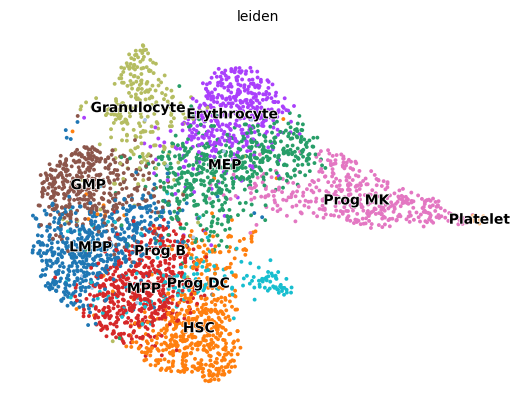

computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


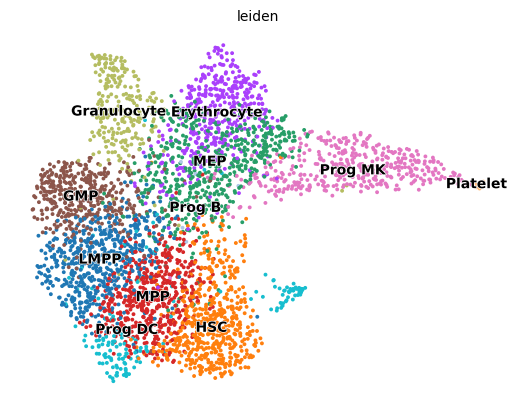

computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


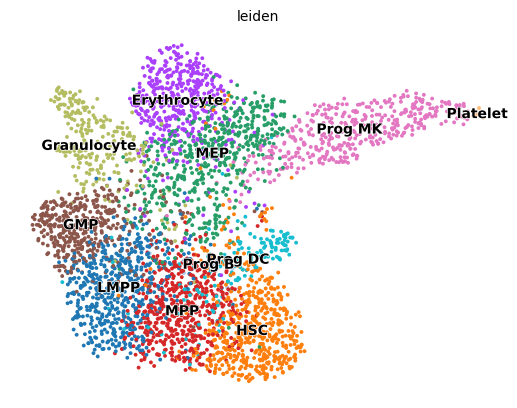

In [7]:
for i in range(len(sub_adata_lst)):
    sub_adata, sub_adata_atac = sub_adata_lst[i]
    sub_adata.layers['raw_spliced'] = sub_adata.layers['spliced'].copy()
    sub_adata.layers['raw_unspliced'] = sub_adata.layers['unspliced'].copy()
    sub_adata.layers['raw_spliced'] = sub_adata.layers['raw_spliced'].astype(int)
    sub_adata.layers['raw_unspliced'] = sub_adata.layers['raw_unspliced'].astype(int)
    if hasattr(sub_adata, "obsm"):
        del sub_adata.obsm
    if hasattr(sub_adata, "obsp"):
        del sub_adata.obsp
    if hasattr(sub_adata, "varm"):
        del sub_adata.varm
    if 'pca' in sub_adata.uns:
        del sub_adata.uns['pca']
    if 'umap' in sub_adata.uns:
        del sub_adata.uns['umap']
    if "neighbors" in sub_adata.uns:
        del sub_adata.uns['neighbors']
    if 'Ms' in sub_adata.layers:
        del sub_adata.layers['Ms']
    if 'Mu' in sub_adata.layers:
        del sub_adata.layers['Mu']
    scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
    utils.fill_in_neighbors_indices(sub_adata)
    sc.tl.umap(sub_adata)
    if issparse(sub_adata.layers['raw_unspliced']):
        sub_adata.obs['u_lib_size_raw'] = sub_adata.layers['raw_unspliced'].toarray().sum(-1) 
        sub_adata.obs['s_lib_size_raw'] = sub_adata.layers['raw_spliced'].toarray().sum(-1)
    else:
        sub_adata.obs['u_lib_size_raw'] = sub_adata.layers['raw_unspliced'].sum(-1) 
        sub_adata.obs['s_lib_size_raw'] = sub_adata.layers['raw_spliced'].sum(-1)
    scv.pl.umap(sub_adata, color=CLUSTER_KEY)
    if SAVE_DATA:
        (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)
        sub_adata.write_h5ad(DATA_DIR / DATASET / "processed" / f"adata_preprocessed_{i}.h5ad")
        sub_adata_atac.write_h5ad(DATA_DIR / DATASET / "processed" / f"adata_atac_preprocessed_{i}.h5ad")
    del sub_adata, sub_adata_atac
    gc.collect()